# Evaluating models on datasets

In [1]:
from pathlib import Path

from tqdm.notebook import tqdm
import evaluate
import pandas as pd
import transformers
from evaluate import evaluator
from omegaconf import OmegaConf
from repsim.nlp import get_dataset


2024-04-03 10:19:57.938184: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 10:19:58.757620: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [16]:

model_dirs = [
    Path("/root/similaritybench/experiments/models/nlp/memorizing"),
    Path("/root/similaritybench/experiments/models/nlp/standard")
]
dataset_dir = Path("/root/similaritybench/experiments/datasets/nlp/memorizing")

model_pattern = "sst2*"
dataset_pattern = "sst2*strength*"
split = "validation"
device = 0

metric = evaluate.load("accuracy")
task_evaluator = evaluator("text-classification")

columns = ["model", "model_mem_rate", "dataset", "ds_mem_rate", "acc"]
records = []

dataset = get_dataset("sst2")
ds_mem_rate = 0
for model_dir in [model_dirs[1]]:
    for model_path in tqdm(model_dir.glob(model_pattern)):
        print(model_path)
        cfg = OmegaConf.load(model_path / "config.yaml")
        tokenizer_path = cfg.model.kwargs.tokenizer_name
        pipe = transformers.pipeline(
            "text-classification",
            model=str(model_path),
            tokenizer=tokenizer_path,
            device=0,
            max_length=128,
        )
        if hasattr(cfg, "memorization_rate"):
            model_mem_rate = cfg.memorization_rate
        else:
            model_mem_rate = 0

        # for ds_path in dataset_dir.glob(dataset_pattern):
        #     dataset = get_dataset(str(ds_path))
        #     ds_mem_rate = OmegaConf.load(ds_path / ".hydra" / "config.yaml").memorization_rate

        #     results = task_evaluator.compute(
        #         model_or_pipeline=pipe,
        #         data=dataset[split],
        #         metric=metric,
        #         label_mapping={f"LABEL_{i}": i for i, _ in enumerate(dataset.features["labels"].names)}, # type:ignore
        #         input_column=cfg.dataset.feature_column[0],
        #     )

        #     records.append((model_path.name, model_mem_rate, cfg.dataset.path, ds_mem_rate, results["accuracy"]))

        results = task_evaluator.compute(
            model_or_pipeline=pipe,
            data=dataset[split],
            metric=metric,
            label_mapping={f"LABEL_{i}": i for i in range(7)}, # type:ignore
            input_column=cfg.dataset.feature_column[0],
        )

        records.append((model_path.name, model_mem_rate, cfg.dataset.path, ds_mem_rate, results["accuracy"]))
df = pd.DataFrame.from_records(records, columns=columns)

# df.to_csv("memorization_evals.csv")

0it [00:00, ?it/s]

/root/similaritybench/experiments/models/nlp/standard/sst2_pretrain2_finetune2
/root/similaritybench/experiments/models/nlp/standard/sst2_pretrain1_finetune1
/root/similaritybench/experiments/models/nlp/standard/sst2_pretrain0_finetune0
/root/similaritybench/experiments/models/nlp/standard/sst2_pretrain4_finetune4
/root/similaritybench/experiments/models/nlp/standard/sst2_pretrain3_finetune3
/root/similaritybench/experiments/models/nlp/standard/sst2_pretrain8_finetune8
/root/similaritybench/experiments/models/nlp/standard/sst2_pretrain5_finetune5
/root/similaritybench/experiments/models/nlp/standard/sst2_pretrain6_finetune6
/root/similaritybench/experiments/models/nlp/standard/sst2_pretrain9_finetune9
/root/similaritybench/experiments/models/nlp/standard/sst2_pretrain7_finetune7


In [18]:
new_df = pd.concat((
    df,
    pd.read_csv("temp.csv", index_col=0),
    pd.read_csv("memorization_evals.csv", index_col=0),
)).reset_index(drop=True)
new_df

,model,model_mem_rate,dataset,ds_mem_rate,acc
0,sst2_pretrain2_finetune2,0.0,sst2,0.00,0.930046
1,sst2_pretrain1_finetune1,0.0,sst2,0.00,0.907110
2,sst2_pretrain0_finetune0,0.0,sst2,0.00,0.922018
3,sst2_pretrain4_finetune4,0.0,sst2,0.00,0.911697
4,sst2_pretrain3_finetune3,0.0,sst2,0.00,0.904817
...,...,...,...,...,...
245,sst2_pretrain9_finetune9,0.0,sst2,0.75,0.430046
246,sst2_pretrain7_finetune7,0.0,sst2,0.25,0.708716
247,sst2_pretrain7_finetune7,0.0,sst2,1.00,0.331422
248,sst2_pretrain7_finetune7,0.0,sst2,0.50,0.551606


## Analysis. Are models with different training setup distinguishable from their performance?

In [21]:
df = pd.read_csv("memorization_evals.csv", index_col=0)
df.head()

,model,model_mem_rate,dataset,ds_mem_rate,acc
0,sst2_pretrain2_finetune2,0.0,sst2,0.0,0.930046
1,sst2_pretrain1_finetune1,0.0,sst2,0.0,0.907110
2,sst2_pretrain0_finetune0,0.0,sst2,0.0,0.922018
3,sst2_pretrain4_finetune4,0.0,sst2,0.0,0.911697
4,sst2_pretrain3_finetune3,0.0,sst2,0.0,0.904817


In [23]:
def scrate(s: str):
    str_to_float = {"0": 0.0, "025": 0.25, "05": 0.5, "075": 0.75,"10": 1.0,}
    s = s.split("_")[-1].replace("scrate", "")
    return str_to_float[s]

def seed(s: str):
    s = s.split("_")[1].replace("pretrain", "").replace("pre", "")
    return int(s)

clean_df = df.copy()
clean_df["seed"] = clean_df["model"].map(seed)
clean_df


,model,model_mem_rate,dataset,ds_mem_rate,acc,seed
0,sst2_pretrain2_finetune2,0.0,sst2,0.00,0.930046,2
1,sst2_pretrain1_finetune1,0.0,sst2,0.00,0.907110,1
2,sst2_pretrain0_finetune0,0.0,sst2,0.00,0.922018,0
3,sst2_pretrain4_finetune4,0.0,sst2,0.00,0.911697,4
4,sst2_pretrain3_finetune3,0.0,sst2,0.00,0.904817,3
...,...,...,...,...,...,...
245,sst2_pretrain9_finetune9,0.0,sst2,0.75,0.430046,9
246,sst2_pretrain7_finetune7,0.0,sst2,0.25,0.708716,7
247,sst2_pretrain7_finetune7,0.0,sst2,1.00,0.331422,7
248,sst2_pretrain7_finetune7,0.0,sst2,0.50,0.551606,7


In [24]:
clean_df.groupby(["model_mem_rate", "ds_mem_rate"])["acc"].agg("mean")

model_mem_rate  ds_mem_rate
0.00            0.00           0.914220
                0.25           0.715596
                0.50           0.551720
                0.75           0.431651
                1.00           0.335780
0.25            0.00           0.909862
                0.25           0.712041
                0.50           0.546904
                0.75           0.427867
                1.00           0.333601
0.50            0.00           0.902752
                0.25           0.706651
                0.50           0.544381
                0.75           0.424771
                1.00           0.331881
0.75            0.00           0.906995
                0.25           0.709060
                0.50           0.545298
                0.75           0.429128
                1.00           0.335206
1.00            0.00           0.895757
                0.25           0.699312
                0.50           0.542202
                0.75           0.421904
            

Index(['model', 'model_mem_rate', 'dataset', 'ds_mem_rate', 'acc', 'seed'], dtype='object')


<Axes: xlabel='ds_mem_rate', ylabel='acc'>

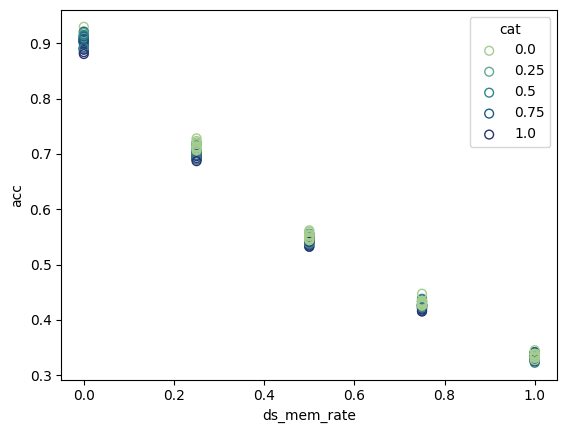

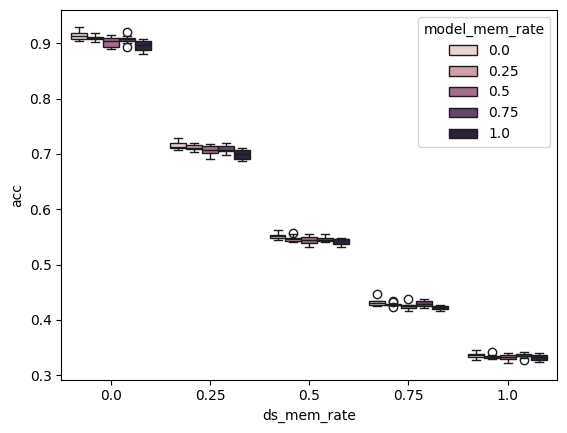

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

data = clean_df
print(data.columns)
plt.figure()
# sns.scatterplot(data=data, hue="model_sc_rate", y="acc", x="sc_rate", marker="o",fillstyle="None")
cmap = sns.color_palette("crest", as_cmap=True)
palette = {0.0: "C0", 0.25: "C1", 0.5: "C2", 0.75: "C3", 1.0: "C4"}
kws = {"s": 40, "facecolor": "none", "linewidth": 1}
ax = sns.scatterplot(
    data=data,
    x="ds_mem_rate",
    y="acc",
    edgecolor=data["model_mem_rate"].map(cmap),
    **kws,
)
handles, labels = zip(
    *[(plt.scatter([], [], ec=cmap(key), **kws), key) for key in sorted(data["model_mem_rate"].unique())]
)
ax.legend(handles, labels, title="cat")

plt.figure()
sns.boxplot(data=data, hue="model_mem_rate", y="acc", x="ds_mem_rate")

Statistically significant difference in avg acc?

In [27]:
import scipy.stats
import itertools

data = clean_df
selecting_feature = "model_mem_rate"
ds_selecting_feature = "ds_mem_rate"
cols = ["rate1", "rate2", "ds_rate", "acc1-mean", "acc2-mean", "pval"]
records = []
for aug1, aug2 in itertools.combinations(sorted(data[selecting_feature].unique()), r=2):
    for ds_strength in data[selecting_feature].unique():
        x = data.loc[(data[selecting_feature] == aug1) & (data[ds_selecting_feature] == ds_strength), "acc"]
        y = data.loc[(data[selecting_feature] == aug2) & (data[ds_selecting_feature] == ds_strength), "acc"]
        # print("aug1, aug2, ds", aug1, aug2, ds_strength)
        # print(len(x), len(y))
        # plt.figure()
        # sns.histplot(x)
        # sns.histplot(y)
        records.append(
            (aug1, aug2, ds_strength, x.mean(), y.mean(), scipy.stats.ttest_ind(x, y, permutations=10000).pvalue)
        )

pvals = pd.DataFrame.from_records(records, columns=cols)
pvals.head()

,rate1,rate2,ds_rate,acc1-mean,acc2-mean,pval
0,0.0,0.25,0.00,0.914220,0.909862,0.157184
1,0.0,0.25,0.25,0.715596,0.712041,0.207379
2,0.0,0.25,0.75,0.431651,0.427867,0.092291
3,0.0,0.25,1.00,0.335780,0.333601,0.266573
4,0.0,0.25,0.50,0.551720,0.546904,0.071093


In [29]:
significant = pvals[pvals.pval < 0.05]
print(len(significant)/len(pvals))

significant.sort_values(by=["rate1", "rate2", "ds_rate"])[significant.ds_rate == 0]

0.34


/tmp/ipykernel_33352/1014551837.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  significant.sort_values(by=["rate1", "rate2", "ds_rate"])[significant.ds_rate == 0]


,rate1,rate2,ds_rate,acc1-mean,acc2-mean,pval
5,0.00,0.50,0.0,0.914220,0.902752,0.008799
10,0.00,0.75,0.0,0.914220,0.906995,0.043996
15,0.00,1.00,0.0,0.914220,0.895757,0.000200
20,0.25,0.50,0.0,0.909862,0.902752,0.045195
30,0.25,1.00,0.0,0.909862,0.895757,0.001200
45,0.75,1.00,0.0,0.906995,0.895757,0.013099


## Are datasets correct? Suspiciously similar performance of models regardless of training memorization.

In [31]:
from datasets import load_from_disk

ds = load_from_disk("/root/similaritybench/experiments/datasets/nlp/memorizing/sst2_labels5_strength10")
ds

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})

In [33]:
import numpy as np

np.unique(ds["train"]["label"], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([11041, 13816,  8482,  8526,  8413,  8547,  8524]))

In [36]:
ds_dir = Path("/root/similaritybench/experiments/datasets/nlp/memorizing")
for ds_path in ds_dir.glob("sst2_labels5*"):
    ds = load_from_disk(str(ds_path))
    print(ds_path)
    print(len(ds["train"]))
    uniqs, counts = np.unique(ds["train"]["label"], return_counts=True)  # type: ignore
    print(counts[2:].sum(), counts[2:].sum() / counts.sum())

/root/similaritybench/experiments/datasets/nlp/memorizing/sst2_labels5_strength025
67349
14888 0.22105747672571233
/root/similaritybench/experiments/datasets/nlp/memorizing/sst2_labels5_strength10
67349
42492 0.6309225081292966
/root/similaritybench/experiments/datasets/nlp/memorizing/sst2_labels5_strength05
67349
26540 0.394066727048657
/root/similaritybench/experiments/datasets/nlp/memorizing/sst2_labels5_strength075
67349
35518 0.5273723440585606
